# Start HACK 2024, University of St. Gallen - Team "Last Minute"

## Loading relevant modules

In [1]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
import requests
from io import BytesIO
from PIL import Image as PILImage
import io
from IPython.display import Image, display

from bs4 import BeautifulSoup
import json

from datetime import datetime

import matplotlib.pyplot as plt

C:\Users\pacos\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\pacos\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
C:\Users\pacos\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\pacos\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Initializing custom labels

Given the high computational complexity of training the model on the whole dataset, we decided to filter 10 products to speed up training and implementation. This allowed us to experiment more and develop optimized solutions that will likely result optimal even in the case of the model trained on the whole data.

The labels will allow us to track the type of food this algorithm will recognize. Given the way the test and train data have been created in the Jupyer Notebook containing the training of the model, to have a correct match we will need to sort them alphabetically.

In [2]:
labels = ["pizza","hamburger","fried_rice","ice_cream","french_fries","chocolate_cake","tacos",
    "lobster_roll_sandwich","lasagna","chicken_wings"]

sorted_labels = sorted(labels)
print(sorted_labels)

['chicken_wings', 'chocolate_cake', 'french_fries', 'fried_rice', 'hamburger', 'ice_cream', 'lasagna', 'lobster_roll_sandwich', 'pizza', 'tacos']


## Storing Nutritional data

For convenience, we stored a table containing the nutritional facts of the products present during the algorithm training. In case one needs to expand the range of products, the relevant information can be either added manually or through APIs (example: https://myfitnesspalapi.com/docs/diary-get/).

In [3]:
import pandas as pd

nutritional_data = {
    'Product': ['pizza', 'hamburger', 'fried_rice', 'ice_cream', 'french_fries', 'chocolate_cake', 
                'tacos', 'lobster_roll_sandwich', 'lasagna', 'chicken_wings'],
    'Calories_100g': [277, 250, 175, 207, 365, 358, 192, 294, 133, 200],
    'Total_Mass_100g':[100,100,100,100,100,100,100,100,100,100],
    'Total_Fat_100g': [12,9,7,11,17,16,10,15,5,13],
    'Total_Carb_100g': [33,32,23,25,63,54,16,32,15,5],
    'Total_Protein_100g': [12,12,4,3.5,3.4,4,9,7,8,14],
    'Total_Fiber_100g': [2.5, 1.2, 0.5, 0.3, 3.2, 1.8, 2.1, 2.8, 0.8, 0.2],  
    'Total_Sodium_100g': [562, 490, 240, 85, 160, 380, 296, 448, 210, 395],  
    'Est_Weight': [450, 200, 300, 160, 125, 150, 130, 180, 200, 150],
}


df = pd.DataFrame(nutritional_data)

#df['Total_Fiber'] = df['Total_Fiber_100g'] * df['Est_Weight'] / 100

# Sort the DataFrame by Product
df = df.sort_values('Product')
df.head()

,Product,Calories_100g,Total_Mass_100g,Total_Fat_100g,Total_Carb_100g,Total_Protein_100g,Total_Fiber_100g,Total_Sodium_100g,Est_Weight
9,chicken_wings,200,100,13,5,14.0,0.2,395,150
5,chocolate_cake,358,100,16,54,4.0,1.8,380,150
4,french_fries,365,100,17,63,3.4,3.2,160,125
2,fried_rice,175,100,7,23,4.0,0.5,240,300
1,hamburger,250,100,9,32,12.0,1.2,490,200


## Initializing the URLs for the image retrieval APIs

We will utilize to foodish api to fetch food images. These images can be filtered by one or multiple type of foods allowed by the API. These images will be fed into algorithm and therefore used to understand whether and when the moodel is producing the desired outputs.

In [4]:
import random

endpoints = ["burger", "pizza"]
# Choose a random endpoint
random_endpoint = random.choice(endpoints)

url_foodish = f"https://foodish-api.com/api/"
url_foodish_dynamic = f"https://foodish-api.com/api/images/{random_endpoint}"

## Loading the Model

We proceed ny loading the model trained with the 10 aliments contained in the `labels` list and `nutritional data` file. In case one wants to use a different model trained on more/fewer aliments, simply changing this line of code will do it.

In [5]:
model = load_model('my_model_101_top_10.h5')

## Main Function

The `fetch_display_predict` function will fetch from the foodish API, feed it into the model, and return the predicted probability of the selected aliment to be the one in the image.

The image will be preprocessed several times to ensure the correct dimensions (i.e., the same used during the model training phase).

Finally, many information will be printed and several visualizations will help the user of this Notebook to grasp information about the nutritional information of the scanned/photographed food.

In [6]:
def fetch_display_predict(dynamic=False, aw=False):
    
    if dynamic:
        response = requests.get(url_foodish_dynamic)
    else:
        response = requests.get(url_foodish)

    soup = BeautifulSoup(response.text, 'html.parser')

    # Convert the dictionary to a string
    str_soup = str(soup)
    # Remove the curly brackets
    str_soup = str_soup.replace('{', '').replace('}', '')

    # Split this string by double quote and colon to get the URL
    parts = str_soup.split('":"')
    # the URL is now the second part
    url_food = parts[1].replace('"', '')
    
    img_random_food = Image(url=url_food)
    #display(img_random_food)
    
    response_new = requests.get(img_random_food.url)
    img_data = response_new.content

    img_pil = PILImage.open(io.BytesIO(img_data))
    img = img_pil.resize((235, 235))  # please use the size the model was trained on
    display(img)

    img = img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    prediction = model.predict([img])
    
    #print(prediction)
    
    predicted_class = np.argmax(prediction)
    prediction_prob = prediction[0, predicted_class]
    predicted_label = sorted_labels[predicted_class]

    predicted_info = df[df['Product'] == predicted_label].drop(columns='Product')
    
    if aw:
        # Get the average weight
        avg_weight = predicted_info['Average_Weight'].values[0]

        # Fluctuating weight
        np.random.seed(0)  # for reproducibility
        fluctuating_weight = np.random.normal(loc = avg_weight, scale = 0.2*avg_weight)
        # Cap the weights to +100% and -100%
        fluctuating_weight = max(min(fluctuating_weight, 2*avg_weight), 0)  

        # Replace the Average_Weight with fluctuating_weight
        predicted_info['Est_Weight'] = fluctuating_weight

    if dynamic:
        print(f"Predicted Item : {predicted_label}")
    print(f"Prediction Probability: {prediction_prob:.2f}")

    print("\nNutritional Information (per 100g):")
    print(f"Calories: {predicted_info['Calories_100g'].values[0]} cal")
    print(f"Fat: {predicted_info['Total_Fat_100g'].values[0]} g")
    print(f"Carbs: {predicted_info['Total_Carb_100g'].values[0]} g")
    print(f"Protein: {predicted_info['Total_Protein_100g'].values[0]} g")
    print(f"Fiber: {predicted_info['Total_Fiber_100g'].values[0]} g")
    print(f"Sodium: {predicted_info['Total_Sodium_100g'].values[0]} mg")

    
    est_weight = predicted_info['Est_Weight'].values[0]
    
    total_calories = predicted_info['Calories_100g'].values[0] * est_weight / 100
    total_fat = predicted_info['Total_Fat_100g'].values[0] * est_weight / 100
    total_carbs = predicted_info['Total_Carb_100g'].values[0] * est_weight / 100
    total_protein = predicted_info['Total_Protein_100g'].values[0] * est_weight / 100
    total_fiber = predicted_info['Total_Fiber_100g'].values[0] * est_weight / 100
    total_sodium = predicted_info['Total_Sodium_100g'].values[0] * est_weight / 100

    print("\nEstimated Serving Information:")
    print(f"Weight: {est_weight} g")
    print(f"Total Calories: {total_calories} cal")
    print(f"Total Fat: {total_fat} g")
    print(f"Total Carbs: {total_carbs} g")
    print(f"Total Protein: {total_protein} g")
    print(f"Total Fiber: {total_fiber} g")
    print(f"Total Sodium: {total_sodium} mg")

    # RDA divided by 3
    rdas = {
        'Fat': 70/3,
        'Carbs': 310/3,
        'Protein': 50/3,
        'Calories': 2000/3,
        'Fiber': 30/3,
        'Sodium': 2300/3
    }

    # macro-nutrient values for the product
    macros = {
        'Fat': total_fat,
        'Carbs': total_carbs,
        'Protein': total_protein,
        'Calories': total_calories,
        'Fiber': total_fiber,
        'Sodium': total_sodium
    }

    df_bar_charts = pd.DataFrame({'RDA': pd.Series(rdas), 'Product': pd.Series(macros)})
    
    fig, axs = plt.subplots(2, 3, figsize=(15,10))

    for i, (name, row) in enumerate(df_bar_charts.iterrows()):
        ax = axs[i // 3, i % 3]
        row.plot(kind='bar', ax=ax, rot=45, color=['#1f77b4', '#ff7f0e'])
        ax.set_title(name)
        ax.set_ylabel('Amount')

    fig.tight_layout()
    plt.show()
    
    return prediction_prob

## Adding some interactions

We added some Jupyter widgets to allow the users to fetch n images, thus testing different types of aliments and tracking the performance of the model during the runtime.

You can tweak the parameters of the `fetch_display_predict` in the code box below. 
- Setting the `dynamic = True` will filter the URLs of the foodish API to return images of only specific aliments.
- Setting `aw = True` will allow the algorithm to incorporate some random error in the Estimated Weight; this may result in more reliable results given the rough estimate of the weight included in the nutrional_data (and not evaluated by the model).

IntText(value=1, description='Number of Predictions:')

Button(description='Make a Prediction', style=ButtonStyle())

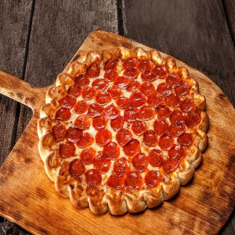

1/1 [==============================] - 1s 1s/step
Predicted Item : pizza
Prediction Probability: 0.96

Nutritional Information (per 100g):
Calories: 277 cal
Fat: 12 g
Carbs: 33 g
Protein: 12.0 g
Fiber: 2.5 g
Sodium: 562 mg

Estimated Serving Information:
Weight: 450 g
Total Calories: 1246.5 cal
Total Fat: 54.0 g
Total Carbs: 148.5 g
Total Protein: 54.0 g
Total Fiber: 11.25 g
Total Sodium: 2529.0 mg


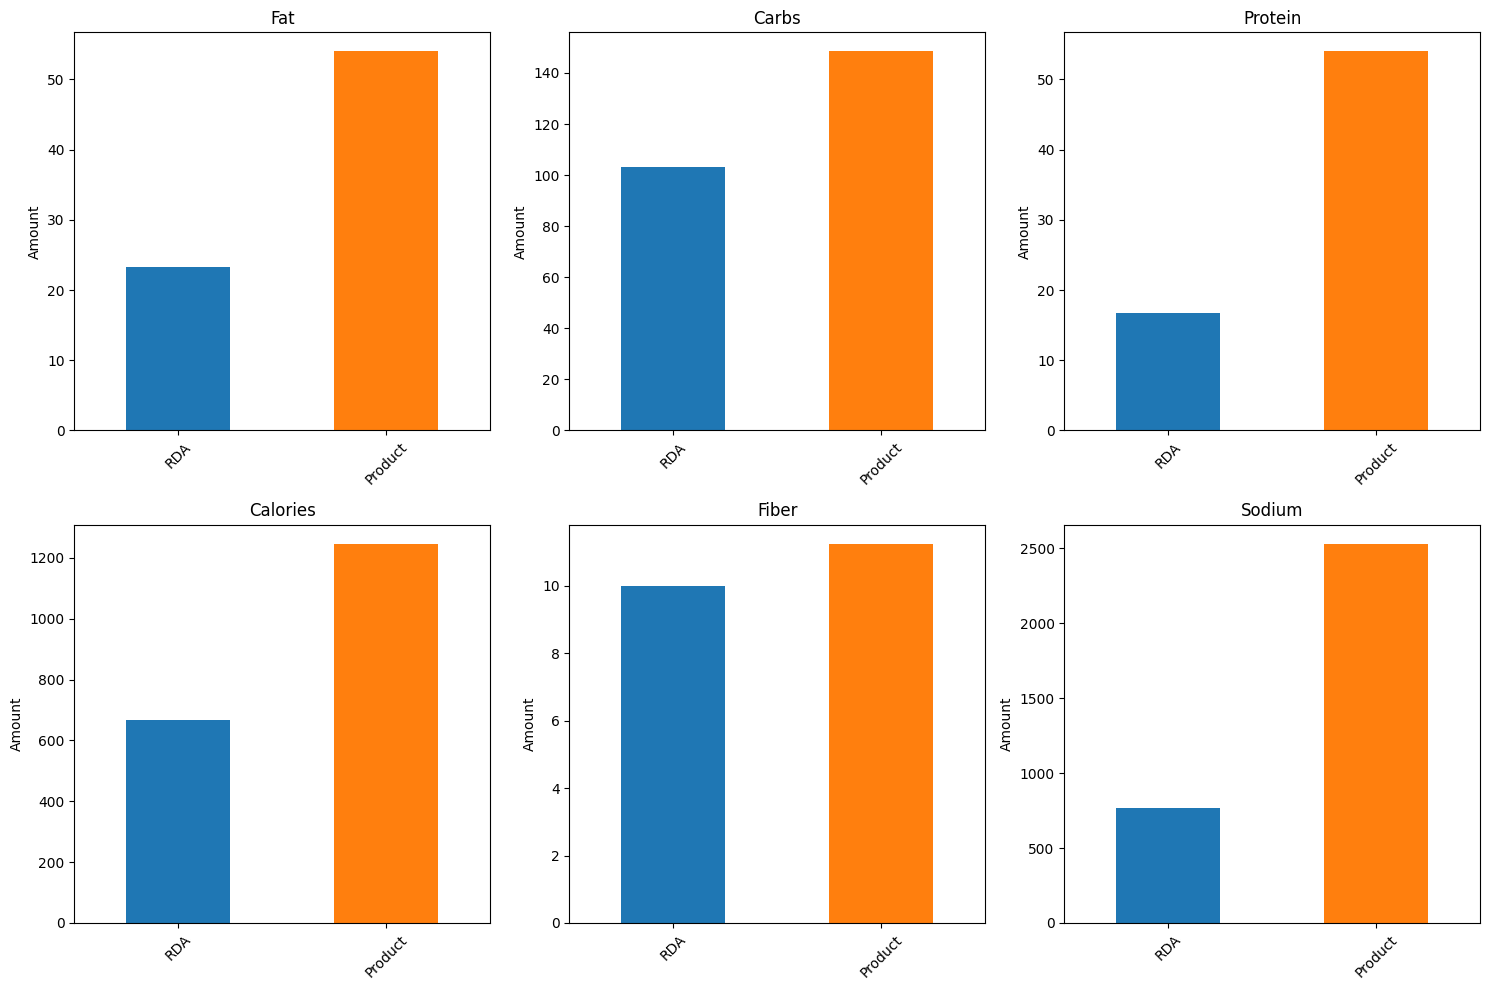

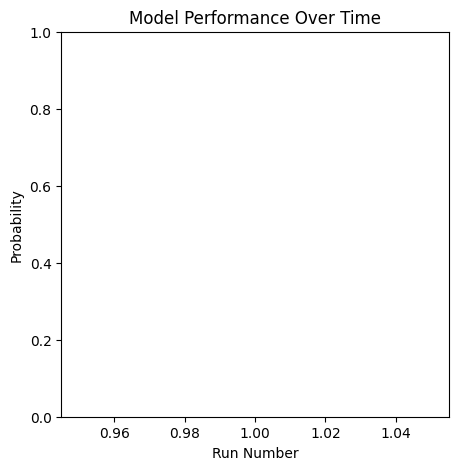

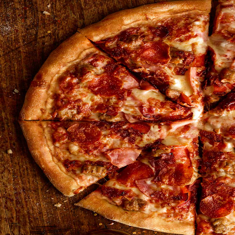

1/1 [==============================] - 0s 106ms/step
Predicted Item : pizza
Prediction Probability: 1.00

Nutritional Information (per 100g):
Calories: 277 cal
Fat: 12 g
Carbs: 33 g
Protein: 12.0 g
Fiber: 2.5 g
Sodium: 562 mg

Estimated Serving Information:
Weight: 450 g
Total Calories: 1246.5 cal
Total Fat: 54.0 g
Total Carbs: 148.5 g
Total Protein: 54.0 g
Total Fiber: 11.25 g
Total Sodium: 2529.0 mg


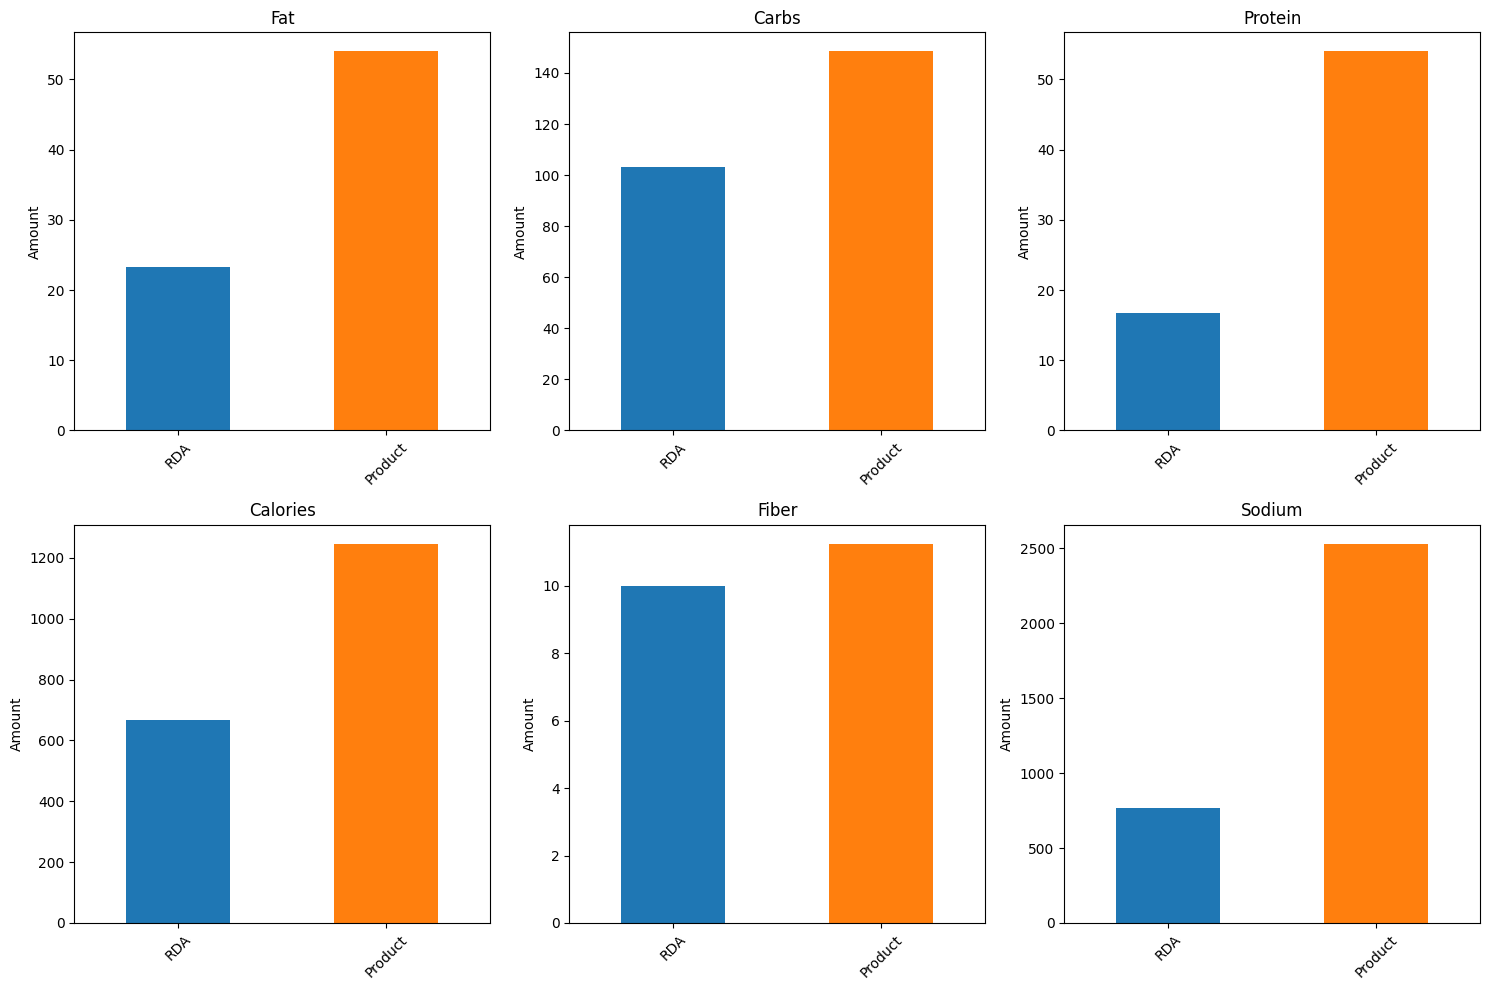

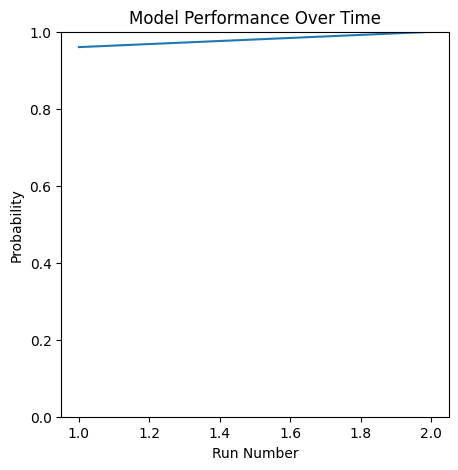

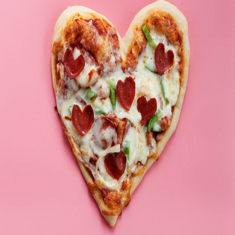

1/1 [==============================] - 0s 104ms/step
Predicted Item : pizza
Prediction Probability: 1.00

Nutritional Information (per 100g):
Calories: 277 cal
Fat: 12 g
Carbs: 33 g
Protein: 12.0 g
Fiber: 2.5 g
Sodium: 562 mg

Estimated Serving Information:
Weight: 450 g
Total Calories: 1246.5 cal
Total Fat: 54.0 g
Total Carbs: 148.5 g
Total Protein: 54.0 g
Total Fiber: 11.25 g
Total Sodium: 2529.0 mg


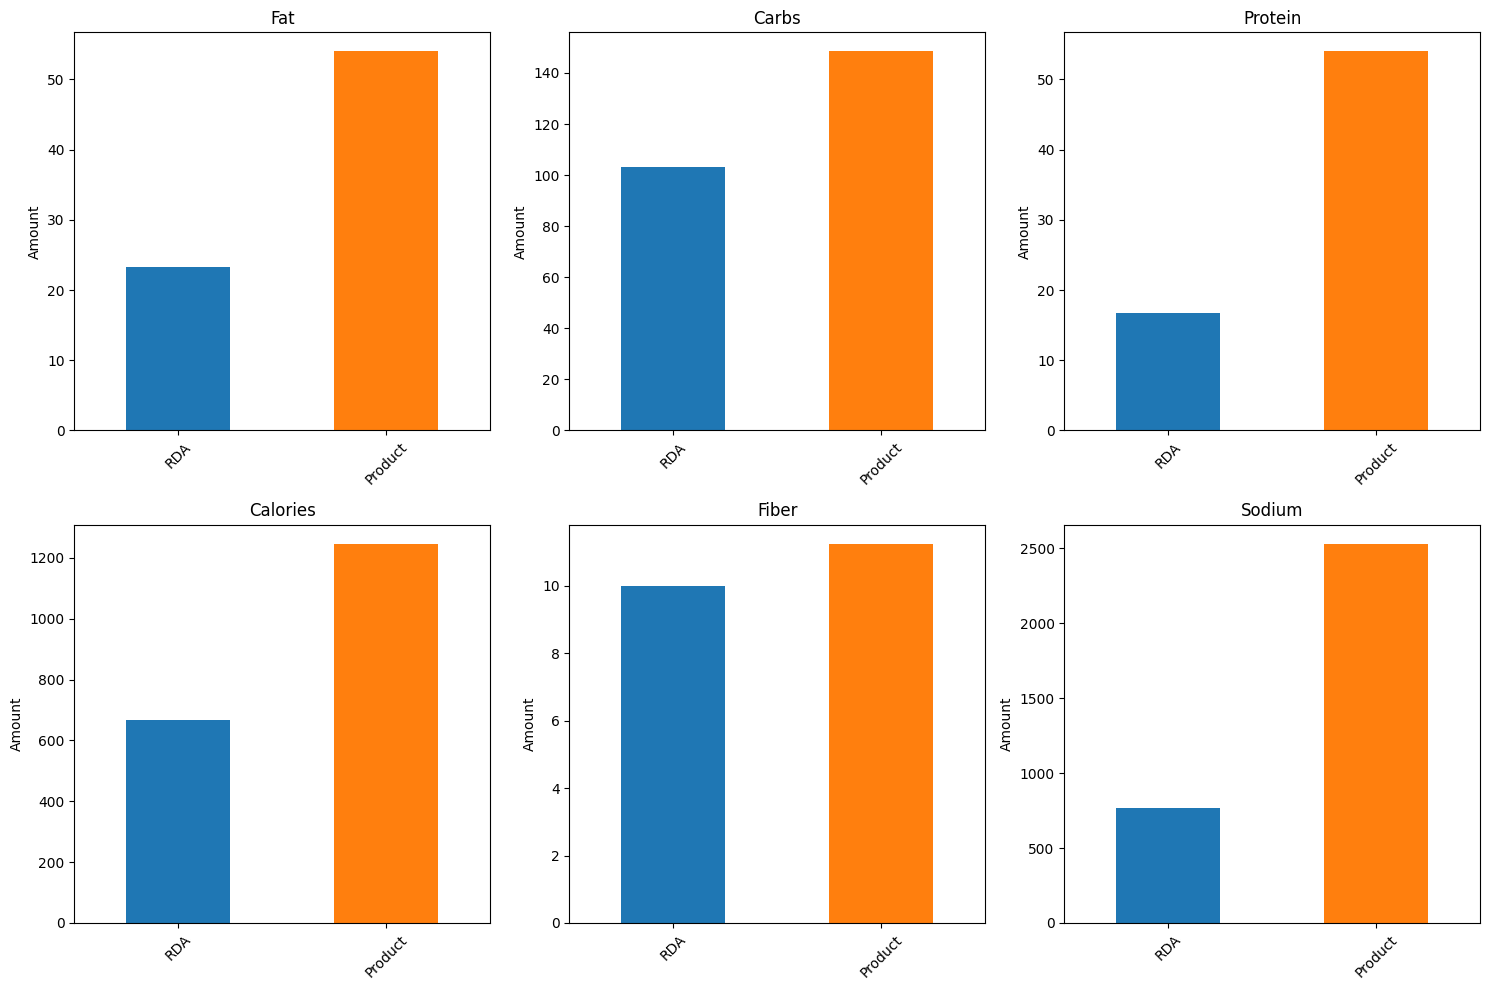

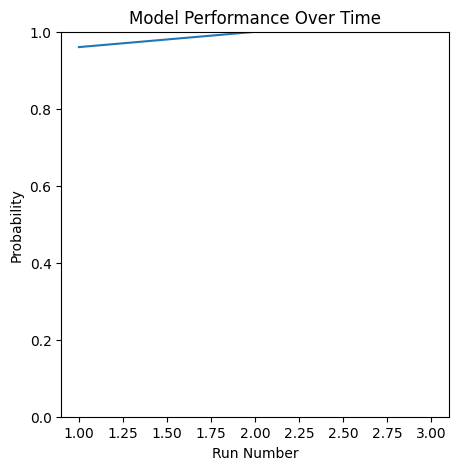

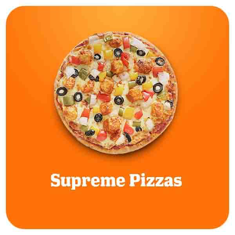

1/1 [==============================] - 0s 69ms/step
Predicted Item : pizza
Prediction Probability: 0.34

Nutritional Information (per 100g):
Calories: 277 cal
Fat: 12 g
Carbs: 33 g
Protein: 12.0 g
Fiber: 2.5 g
Sodium: 562 mg

Estimated Serving Information:
Weight: 450 g
Total Calories: 1246.5 cal
Total Fat: 54.0 g
Total Carbs: 148.5 g
Total Protein: 54.0 g
Total Fiber: 11.25 g
Total Sodium: 2529.0 mg


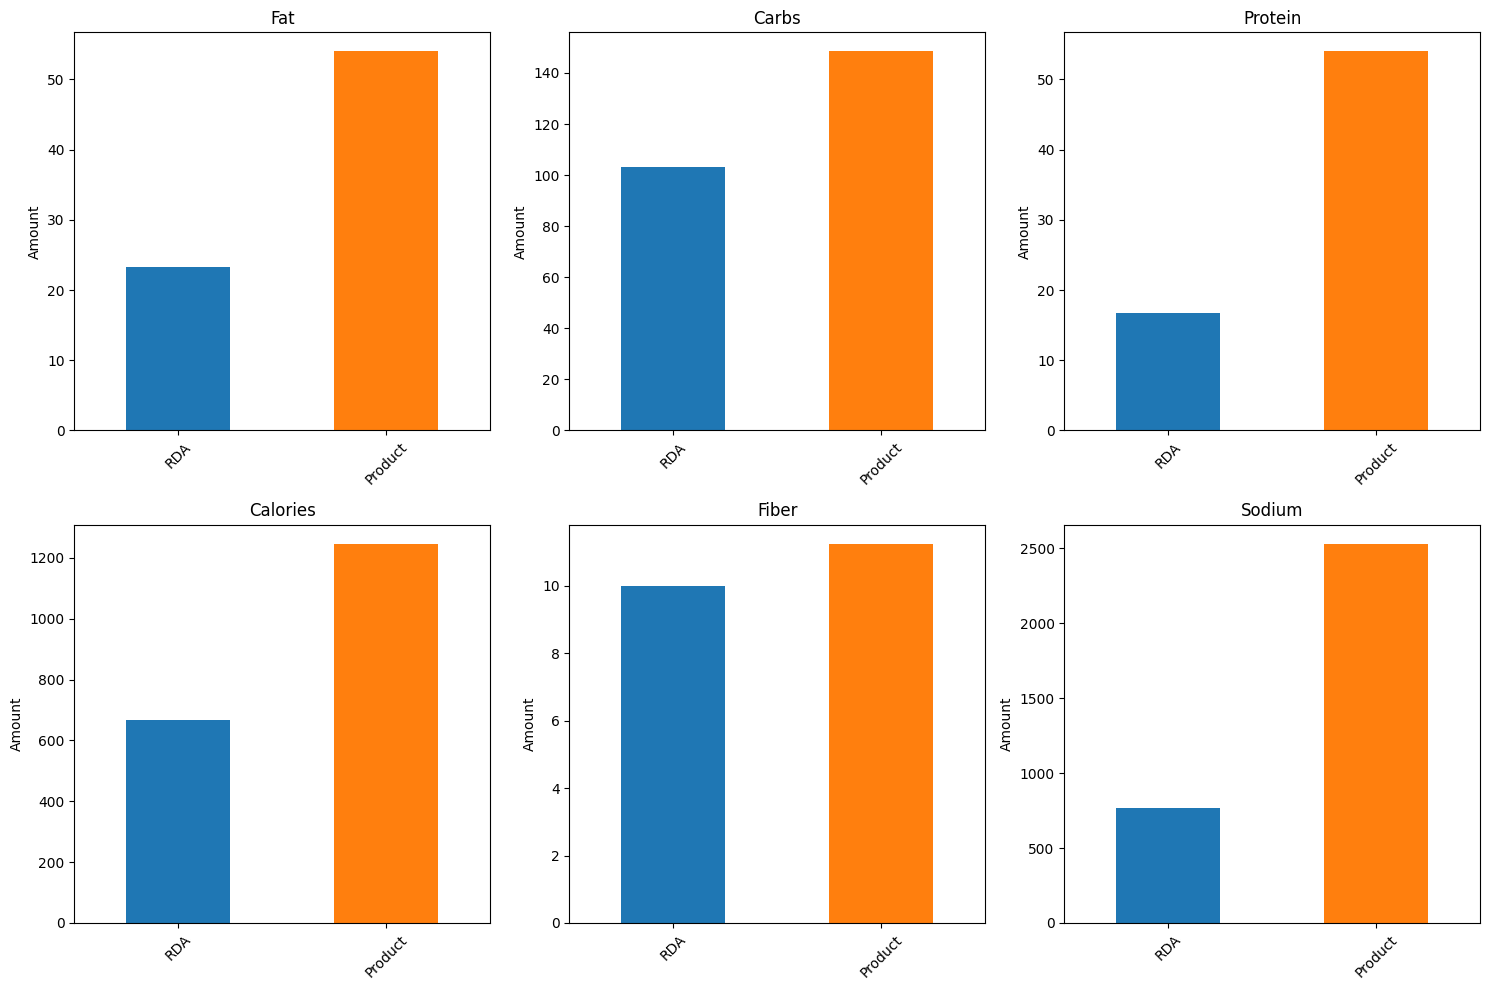

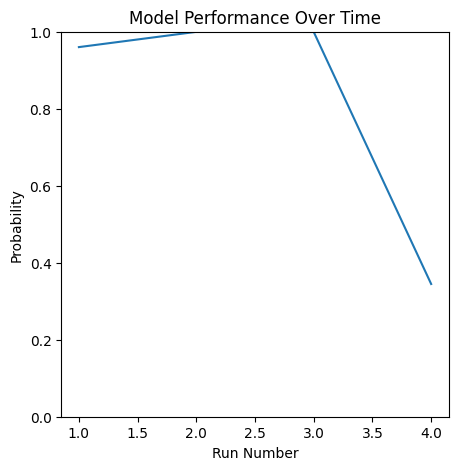

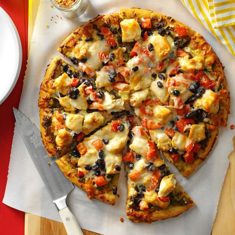

1/1 [==============================] - 0s 96ms/step
Predicted Item : pizza
Prediction Probability: 1.00

Nutritional Information (per 100g):
Calories: 277 cal
Fat: 12 g
Carbs: 33 g
Protein: 12.0 g
Fiber: 2.5 g
Sodium: 562 mg

Estimated Serving Information:
Weight: 450 g
Total Calories: 1246.5 cal
Total Fat: 54.0 g
Total Carbs: 148.5 g
Total Protein: 54.0 g
Total Fiber: 11.25 g
Total Sodium: 2529.0 mg


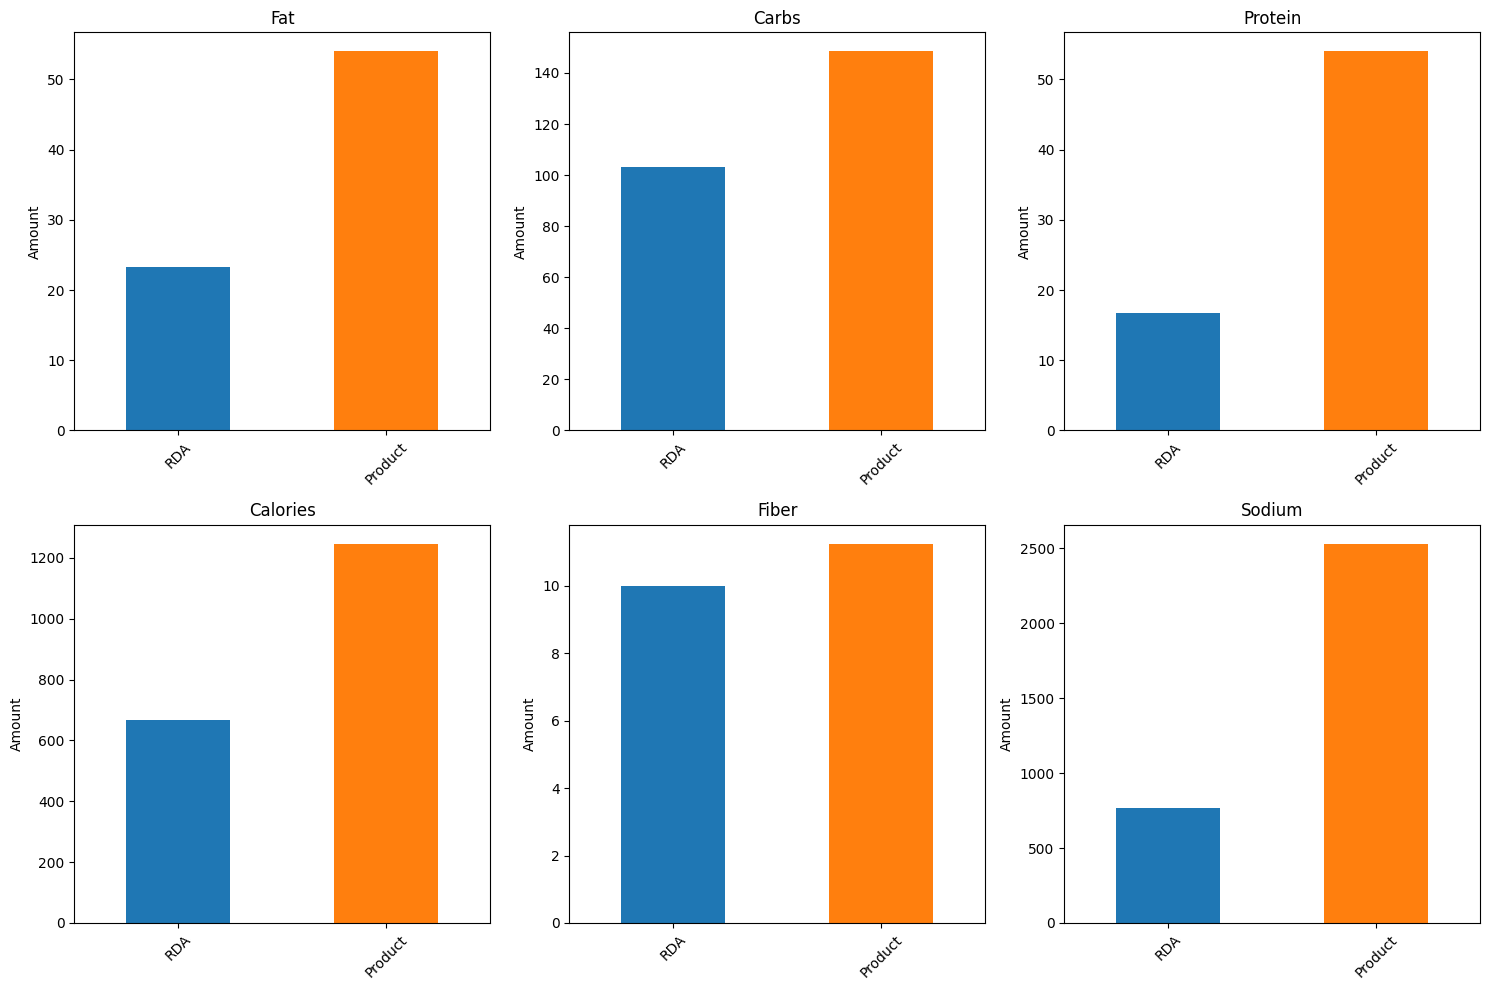

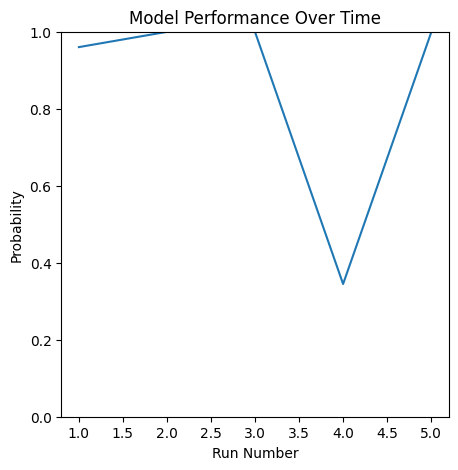

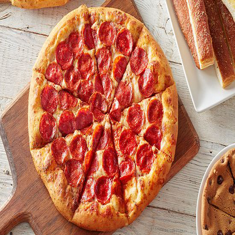

1/1 [==============================] - 0s 104ms/step
Predicted Item : pizza
Prediction Probability: 1.00

Nutritional Information (per 100g):
Calories: 277 cal
Fat: 12 g
Carbs: 33 g
Protein: 12.0 g
Fiber: 2.5 g
Sodium: 562 mg

Estimated Serving Information:
Weight: 450 g
Total Calories: 1246.5 cal
Total Fat: 54.0 g
Total Carbs: 148.5 g
Total Protein: 54.0 g
Total Fiber: 11.25 g
Total Sodium: 2529.0 mg


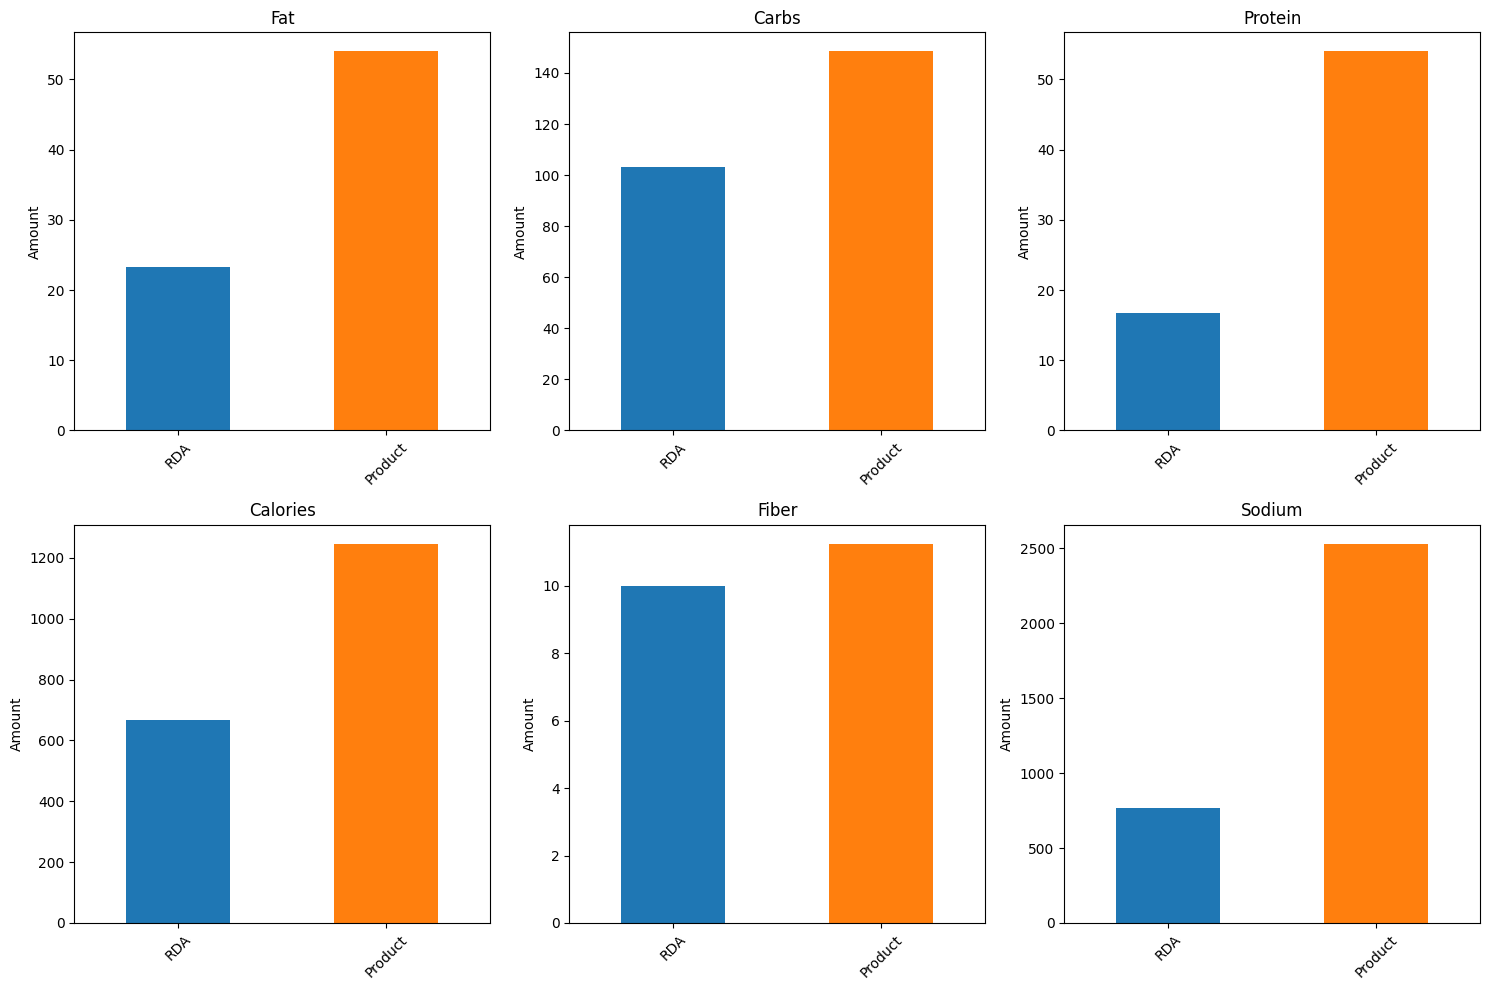

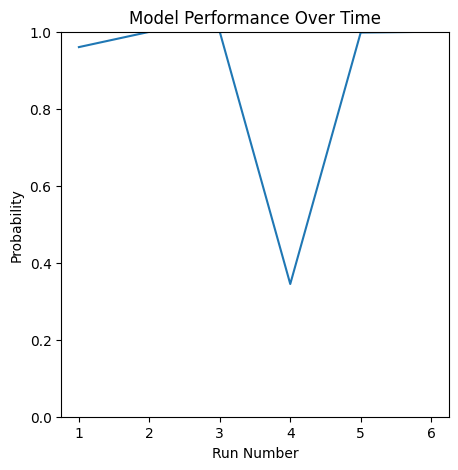

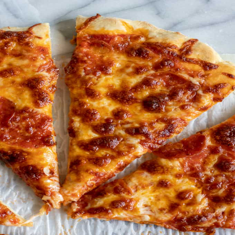

1/1 [==============================] - 0s 102ms/step
Predicted Item : pizza
Prediction Probability: 1.00

Nutritional Information (per 100g):
Calories: 277 cal
Fat: 12 g
Carbs: 33 g
Protein: 12.0 g
Fiber: 2.5 g
Sodium: 562 mg

Estimated Serving Information:
Weight: 450 g
Total Calories: 1246.5 cal
Total Fat: 54.0 g
Total Carbs: 148.5 g
Total Protein: 54.0 g
Total Fiber: 11.25 g
Total Sodium: 2529.0 mg


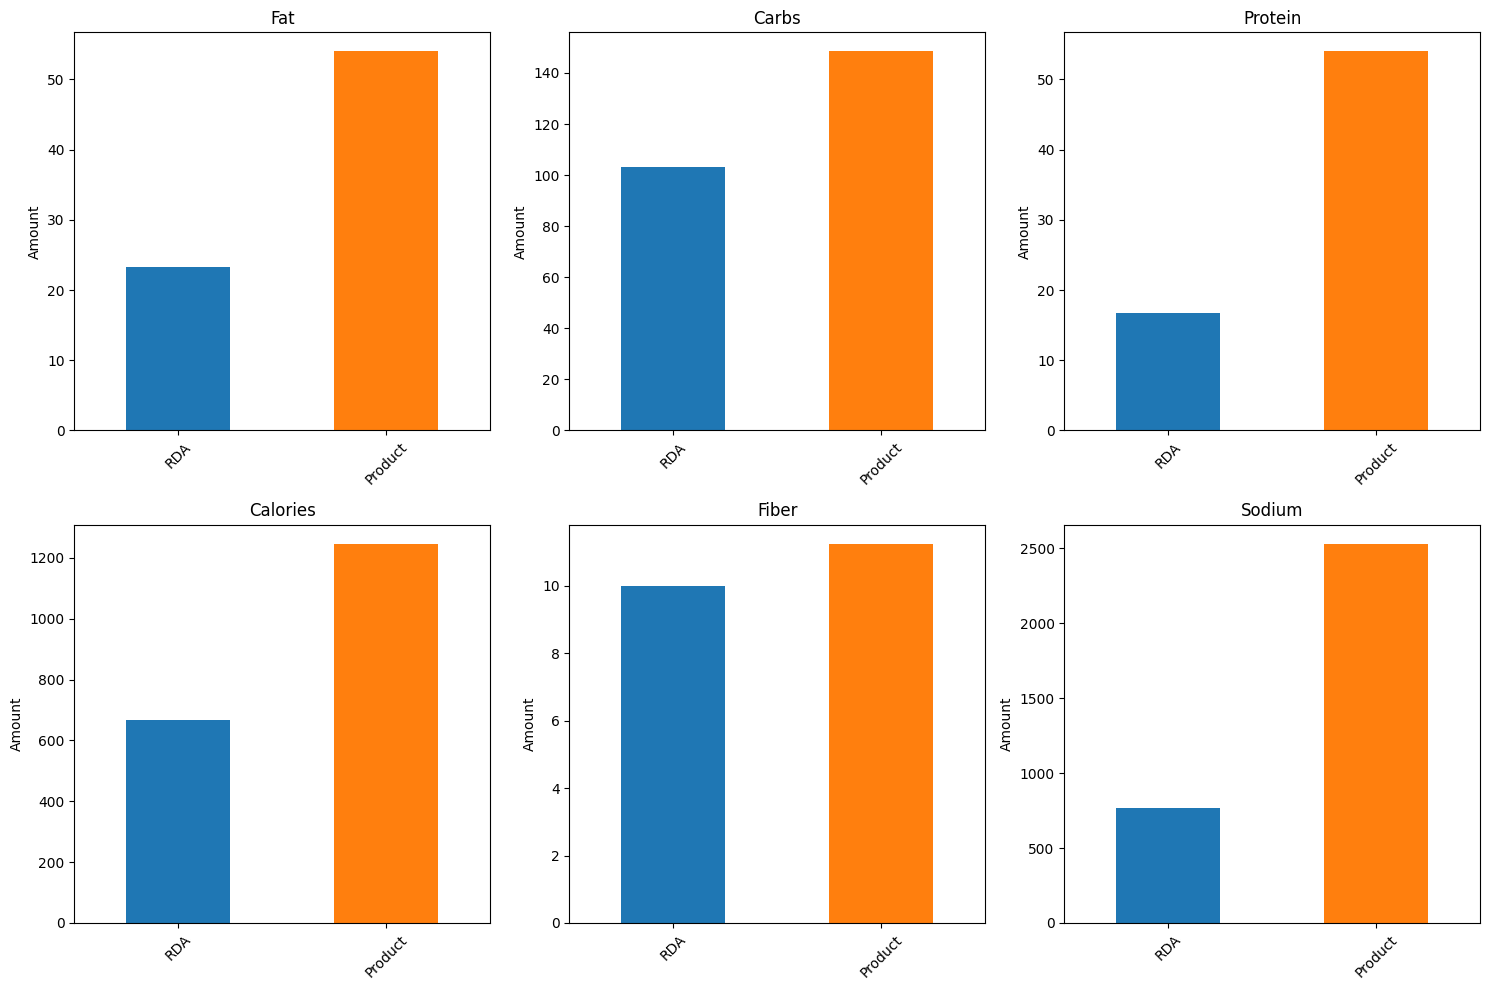

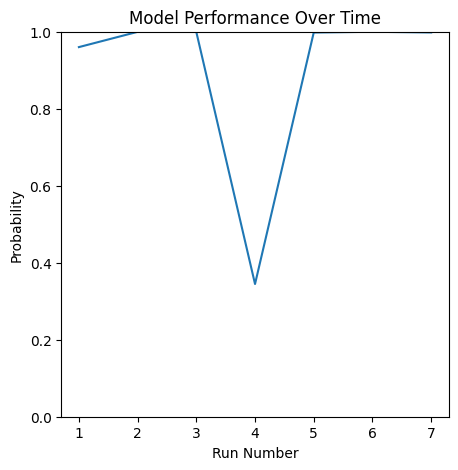

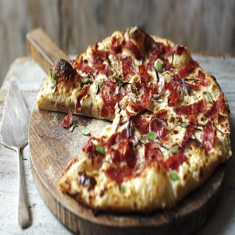

1/1 [==============================] - 0s 96ms/step
Predicted Item : pizza
Prediction Probability: 1.00

Nutritional Information (per 100g):
Calories: 277 cal
Fat: 12 g
Carbs: 33 g
Protein: 12.0 g
Fiber: 2.5 g
Sodium: 562 mg

Estimated Serving Information:
Weight: 450 g
Total Calories: 1246.5 cal
Total Fat: 54.0 g
Total Carbs: 148.5 g
Total Protein: 54.0 g
Total Fiber: 11.25 g
Total Sodium: 2529.0 mg


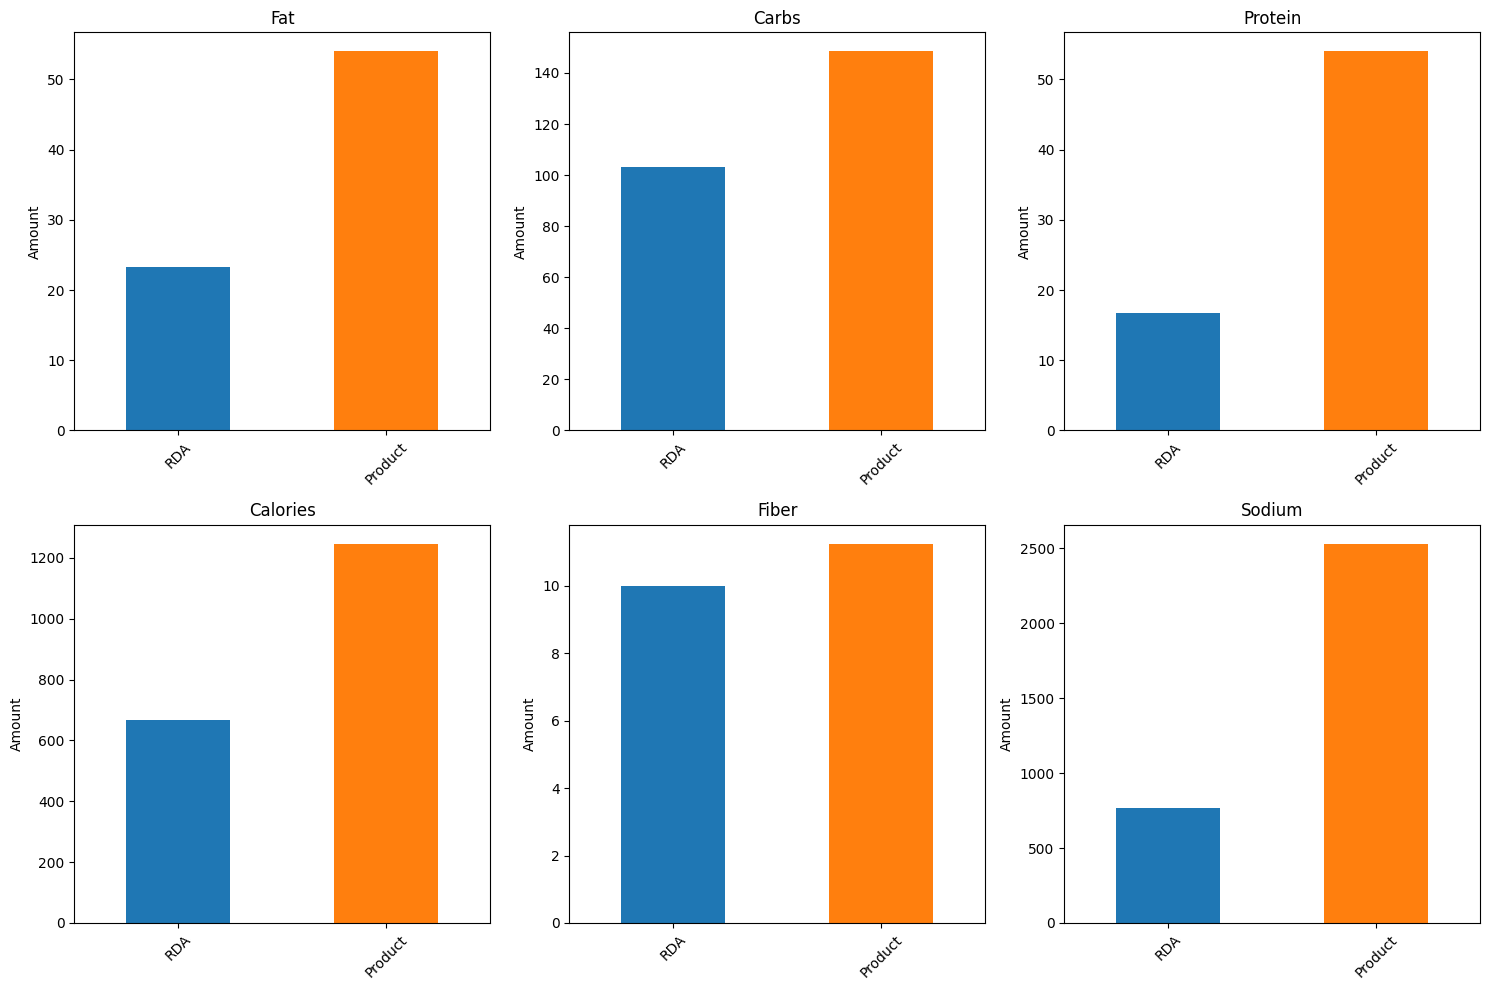

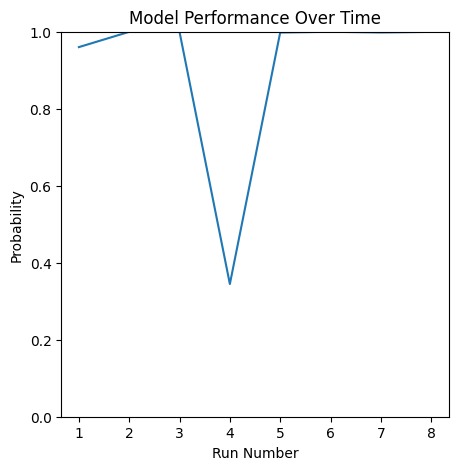

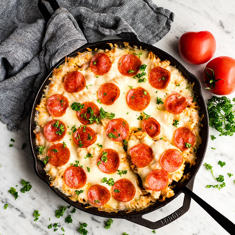

1/1 [==============================] - 0s 77ms/step
Predicted Item : pizza
Prediction Probability: 1.00

Nutritional Information (per 100g):
Calories: 277 cal
Fat: 12 g
Carbs: 33 g
Protein: 12.0 g
Fiber: 2.5 g
Sodium: 562 mg

Estimated Serving Information:
Weight: 450 g
Total Calories: 1246.5 cal
Total Fat: 54.0 g
Total Carbs: 148.5 g
Total Protein: 54.0 g
Total Fiber: 11.25 g
Total Sodium: 2529.0 mg


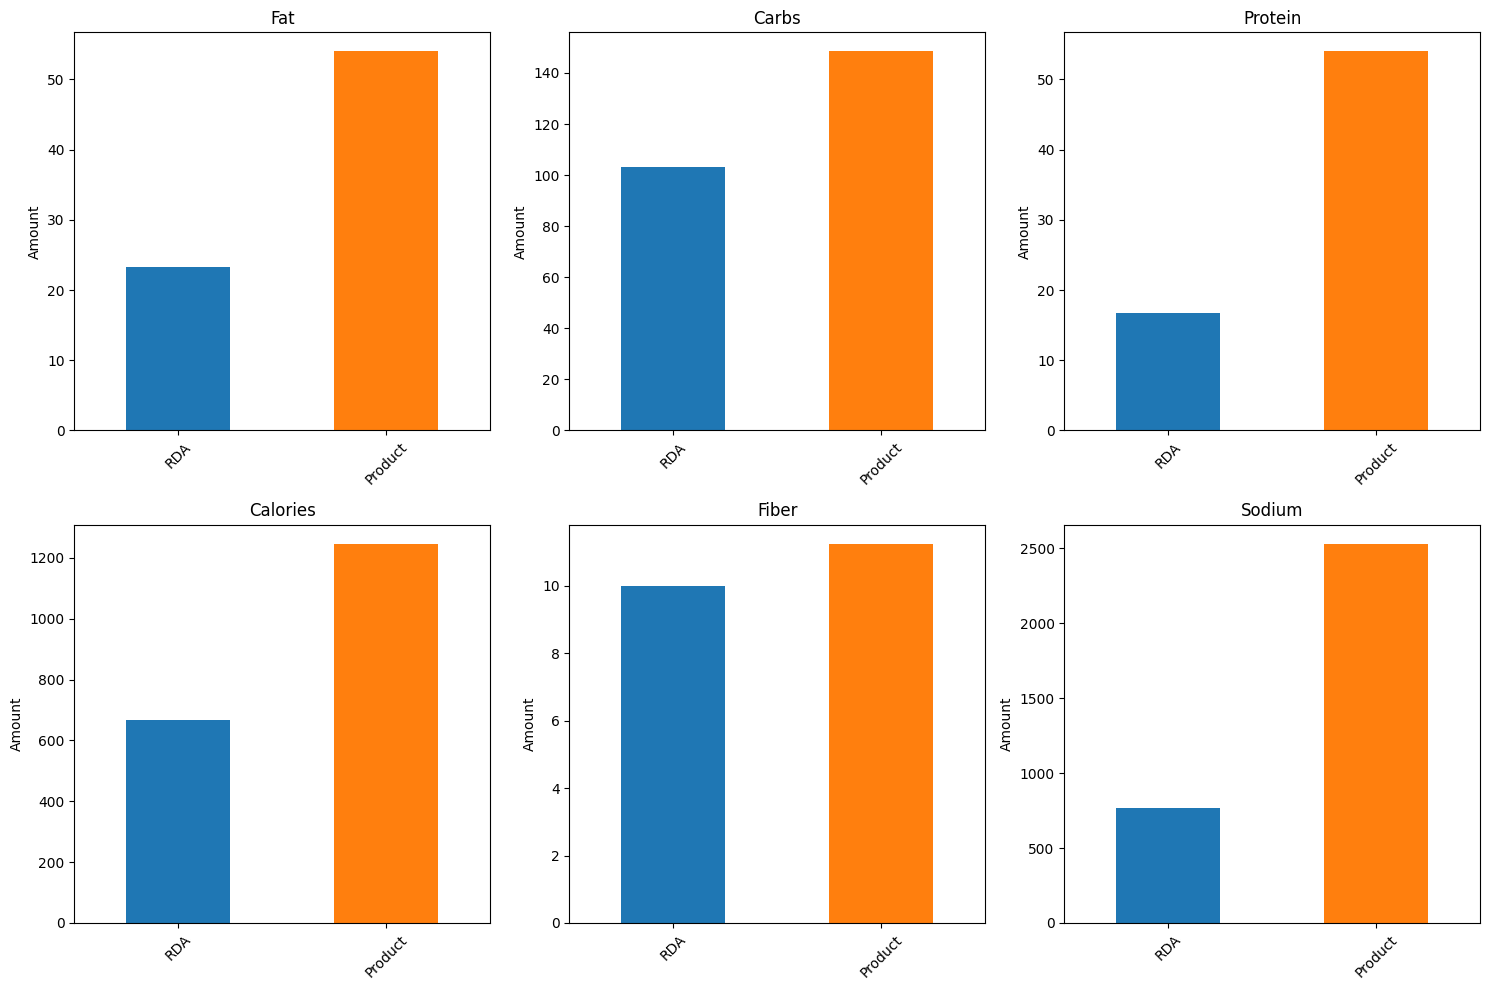

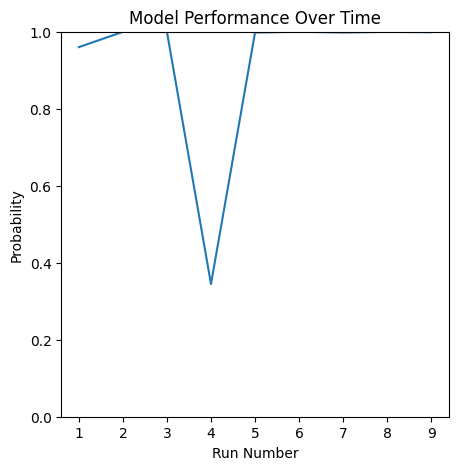

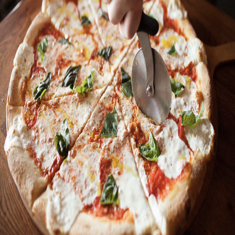

1/1 [==============================] - 0s 88ms/step
Predicted Item : pizza
Prediction Probability: 0.98

Nutritional Information (per 100g):
Calories: 277 cal
Fat: 12 g
Carbs: 33 g
Protein: 12.0 g
Fiber: 2.5 g
Sodium: 562 mg

Estimated Serving Information:
Weight: 450 g
Total Calories: 1246.5 cal
Total Fat: 54.0 g
Total Carbs: 148.5 g
Total Protein: 54.0 g
Total Fiber: 11.25 g
Total Sodium: 2529.0 mg


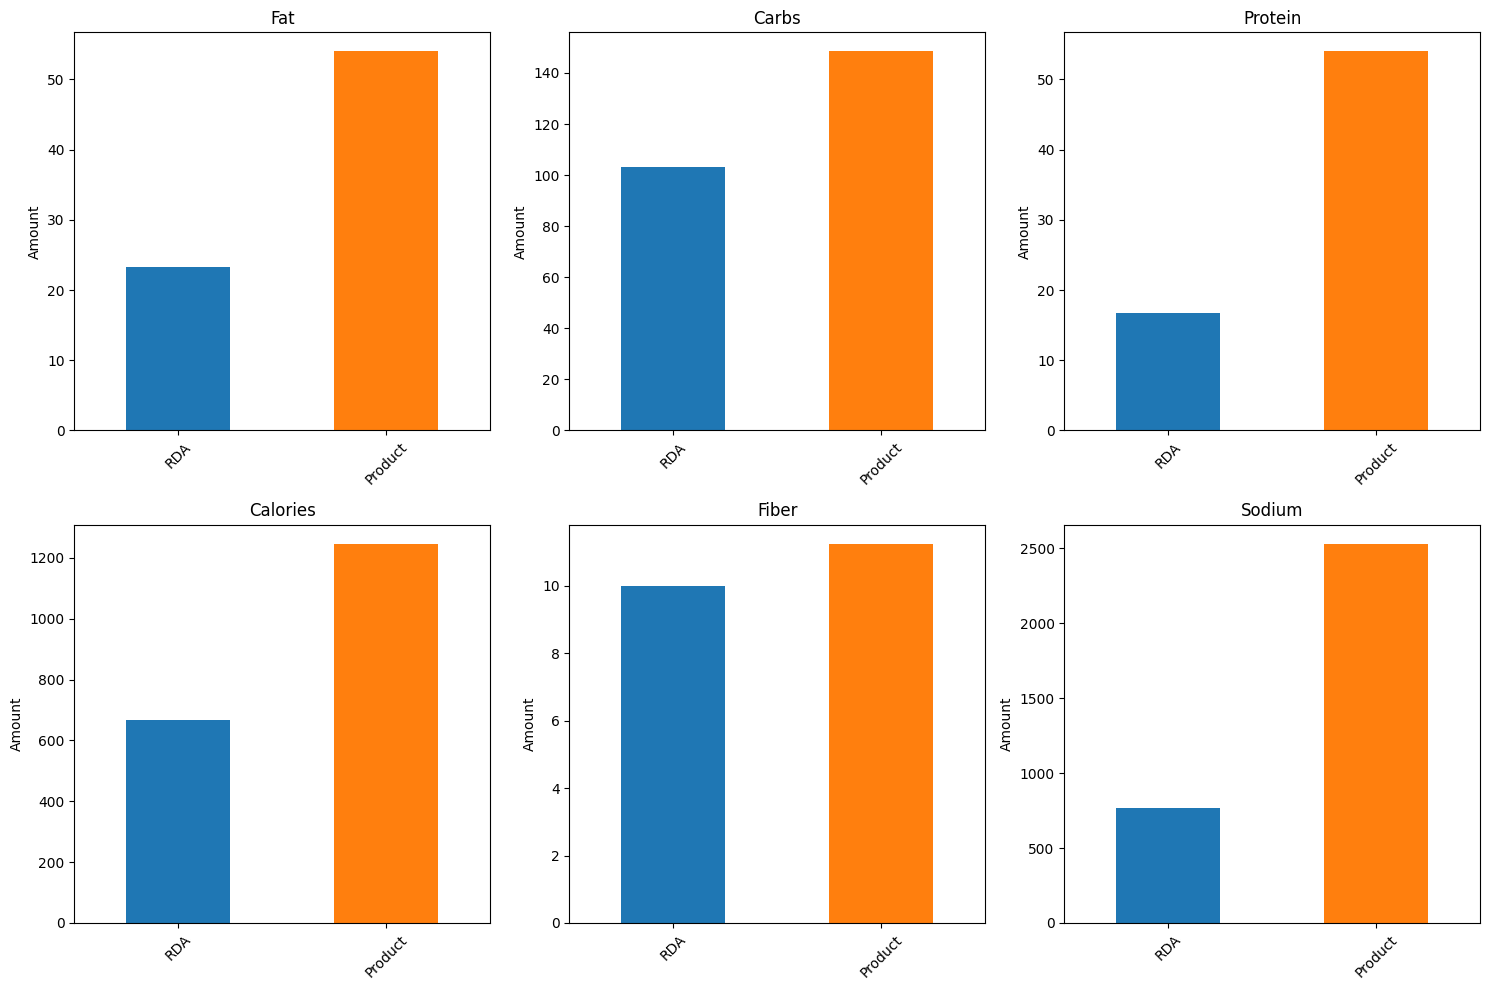

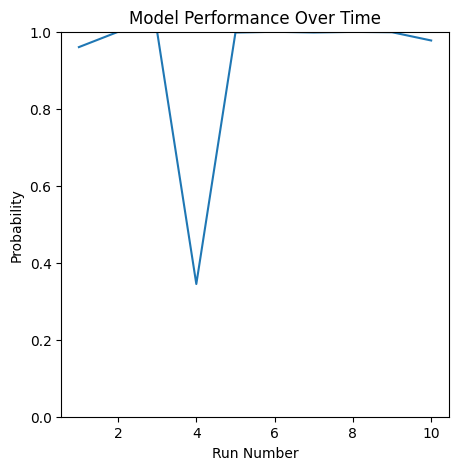

In [7]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# List to store the probabilities
progress = []

# Create an integer input widget with a default value
num_predictions = widgets.IntText(value=1, description='Number of Predictions:', disabled=False)

# Display the widget
display(num_predictions)

# Button click
def on_button_click(b):
    for _ in range(num_predictions.value):
        pred_prob = fetch_display_predict(dynamic=False, aw=False)

        # Add the prediction probability to the progress list
        progress.append(float(pred_prob))

        # Redraw graph on 'progress' update
        plt.figure(figsize=(5, 5))
        plt.plot(range(1, len(progress)+1), progress)
        plt.title('Model Performance Over Time')
        plt.xlabel('Run Number')
        plt.ylabel('Probability')
        plt.ylim([0, 1]) 
        plt.show()

# Create a button widget
button = widgets.Button(description='Make a Prediction')

# Set the on_button_click function to be called when the button is clicked
button.on_click(on_button_click)

# Display the button
display(button)

import warnings
warnings.filterwarnings('ignore')
